# Lorentz Transformations

In [1]:
from __future__ import (division, print_function, absolute_import)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

The Lorentz tranformations in a single space coordinate are given by:

$$
\left( 
\begin{array}{c} 
t^\prime \\
x^\prime
\end{array}
\right) 
= \gamma \cdot 
\left( \begin{array}{c c} 
1 & -\frac{v}{c^2} \\
-v & 1
\end{array}
\right) 
\cdot
\left( \begin{array}{c} 
t \\
x 
\end{array}
\right) 
$$

with

$$
\gamma = \frac{1}{\sqrt{1-\frac{v^2}{c^2}}}
$$

In the following demonstration we measure distances in light seconds, which computationally amounts to setting $c=1$.

In [154]:
class LorentzTrafo:
    def __init__(self, v):
        self.v = v
        self.gamma = np.sqrt(1-v*v)
        self.matrix = self.gamma * np.array([[1, -v], [-v, 1]])
        
    def __call__(self, obj):
        """
        Takes a single spacetime coordinates (t1, x1),
        or an array of spacetime coordinates [(t1, x1), (t2, x2), ...]
        or pairs of coordinates representing lines [[(t1, x1), (t2, x2)], [...]]
        and returns their respective Lorentz-boosted image
        """
        if len(np.shape(obj)) == 3 and np.shape(obj)[1:3] == (2,2):
            return self.transform_lines(obj)
        elif len(np.shape(obj)) == 1 and np.shape(obj)[0] == 2: 
            return np.matmul(self.matrix, np.transpose(obj)).T
        elif len(np.shape(obj)) == 2 and np.shape(obj)[1] == 2: 
            return np.matmul(self.matrix, np.transpose(obj)).T
        else:
            raise ValueError("Can't transform this object")

    def transform_lines(self, lines):
        """transform a set of pair of points (in one go)"""        
        points = np.reshape(lines, [-1, 2])
        transformed = self.__call__(points)
        return np.reshape(transformed, [-1, 2, 2])    

    
# Verifying:
v=.5
lt = LorentzTrafo(v)
res = lt([[4,2], [6,3]])
res[0], res[1], lt([[[4,2], [6,3]]])

(array([2.59807621, 0.        ]),
 array([ 3.89711432e+00, -2.22044605e-16]),
 array([[[ 2.59807621e+00,  0.00000000e+00],
         [ 3.89711432e+00, -2.22044605e-16]]]))

In [162]:
class MinkowskiGrid:
    """A class to hold a grid of space time events and the characteristic world lines"""
    def __init__(self, first, last, left, right, step, v=0.5):
    
        N_wl = 10
        
        self.line_color = '#F0C0C0'

        self.left = left
        self.right = right
        self.first = first
        self.last = last
        self.step = step
        self.v = v
        self.events=[]
        
        tr = range(first, last+1)
        self.xlines = [[[t, left], [t, right]] for t in range(first, last+1)]

        xr = range(left, right+1)
        self.tlines = [[[first, x], [last, x]] for x in range(left, right+1)]

        self.lines = np.append(self.xlines, self.tlines)
        
        self.points = np.array([(t, x) for x in range(left, right+1) 
                       for t in range(first, last+1)])

        self.other = list(zip(np.linspace(first, last, N_wl),
             np.linspace(first*v, last*v, N_wl)))

        self.mytime = [(t, 0) for t in np.linspace(0, last, N_wl)]
        
        r = list(zip(np.linspace(0, last, N_wl),
             np.linspace(0, last, N_wl)))
        l = list(zip(np.linspace(0, last, N_wl),
             np.linspace(0, -last, N_wl)))
        self.light_cone = np.append(r, l, axis=0)
        
    def record_events(self, events):
        self.events = events

    def boost(self, events):
        return LorentzTrafo(self.v)(events)

In [163]:
class MinkowskiPlot():

    def __init__(self, grid):
        self.grid = grid
        self.psize=60
    
    @staticmethod
    def to_mpl_lines(minkowski_lines, color):
        return np.array([[
            [p[0][1], p[1][1]], 
            [p[0][0], p[1][0]], 
            color] 
            for p in minkowski_lines]).reshape(-1)
        
    @staticmethod
    def to_mpl(tx):
        return np.transpose(zip(np.transpose(tx)[1],np.transpose(tx)[0]))
        
    def points_xy(self):
        return np.array(list(zip(self.grid.points.T[1], self.grid.points.T[0]))).T

    def mytime_xy(self, primed=False):
        mytime = LorentzTrafo(grid.v)(grid.mytime) if primed else grid.mytime
        return self.to_mpl(mytime)

    def light_xy(self, primed=False):
        light_cone = grid.boost(grid.light_cone) if primed else grid.light_cone
        return self.to_mpl(light_cone)

    def other_xy(self, primed):
        other = grid.boost(grid.other) if primed else grid.other
        return self.to_mpl(other)

    def events_xy(self, primed):
        events = grid.boost(grid.events) if primed else grid.events
        return self.to_mpl(events)
    
    def tlines_xy(self, color):
        return self.to_mpl_lines(self.grid.tlines, color)
    
    def xlines_xy(self, color):
        return self.to_mpl_lines(self.grid.xlines, color)
    
    def any_xy(self):
        return np.array([p for p in self.points_xy().T if not self.grid.is_light(p) 
                         and not self.grid.is_other(p) 
                         and not self.grid.is_mytime(p)])    

    
    def plot_grid(self, axis, color='#FFC0C0'):
        #axis.plot([self.grid.left, self.grid.right], [0, 0], 'k');
        axis.plot(*self.tlines_xy(color));
        axis.plot(*self.xlines_xy(color));

    def plot_mytime(self, axis, color='r', primed=False):
        axis.scatter(*self.mytime_xy(primed), color=color, marker='o', s=self.psize);
        axis.plot([0,0], [self.grid.first, self.grid.last], color);
    
    def plot_lightcone(self, axis, color='y', primed=False):
        axis.plot([self.grid.left, 0, self.grid.right], 
                  [self.grid.last, 0, self.grid.last], 'y');
        axis.scatter(*self.light_xy(primed), color='y', marker='o', s=self.psize);
    
    def plot_other(self, axis, color='b', primed=False):
        axis.plot([0,self.grid.v*self.grid.right], [0, self.grid.right], color);        
        axis.scatter(*self.other_xy(primed), color=color, marker='o', s=self.psize);

    def plot_events(self, axis, color='k', primed=False):
        axis.scatter(*self.events_xy(primed), color=color, marker='o', s=2.0*self.psize);
        
    def display(self, axis, primed=False):
        if primed:
            tlines_d=self.to_mpl_lines(grid.boost(grid.tlines), '#FFC0C0')
            xlines_d=self.to_mpl_lines(grid.boost(grid.xlines), '#FFC0C0')
            self.plot_grid(axis, color='#A0A0FF')
            axis.plot(*xlines_d, color='#FFD0D0');
            axis.plot(*tlines_d, color='#FFD0D0');
        else:
            self.plot_grid(axis, '#FFC0C0')
            
        self.plot_mytime(axis, 'r', primed)
        self.plot_lightcone(axis, 'y', primed)
        self.plot_other(axis, 'b', primed)
        if (grid.events):
            self.plot_events(axis, 'k', primed)

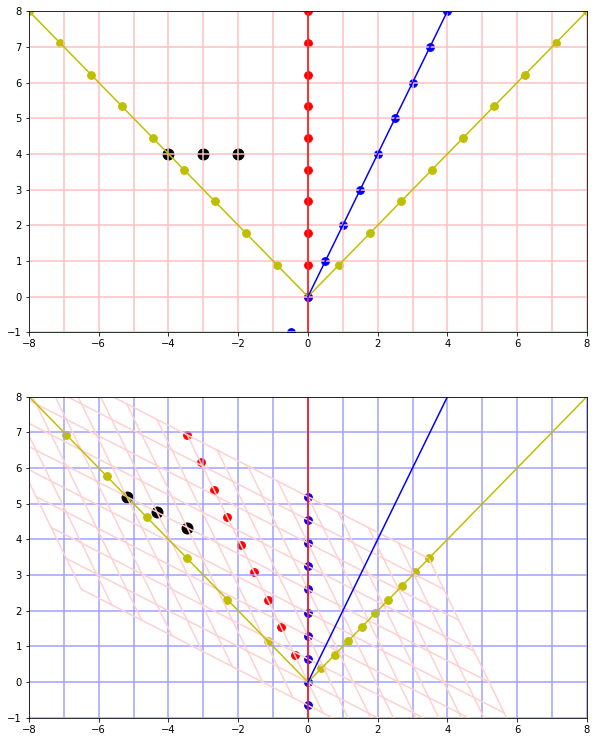

In [169]:
v=.5
grid = MinkowskiGrid(-1, 8, -8, 8, 1, v)
events=[[4, -2], [4, -3], [4, -4]]
grid.record_events(events)
plotter = MinkowskiPlot(grid)
_, plots = plt.subplots(2, figsize=(10,13))
for i in range(2):
    plots[i].set_xlim([-8, 8])
    plots[i].set_ylim([-1, 8])
plotter.display(plots[0], primed=False)
plotter.display(plots[1], primed=True)

We observe the following characteristics:
- Events that appear simultaneous in one reference frame (black dots) will not be observed as simultaneous from within a reference frame moving relative to the former.
- The light cones get stretched or squished but they are observed at the sample angle in space time, i.e the speed of light is constant, independent of the movement of the observer.
- The distance between the outer events (2 light seconds in the upper plot) is slightly contracted to about 1.7321 light seconds from the perspective of the moving observer

In [166]:
 -5.19615242+3.46410162

-1.7320507999999997

In [159]:
lt=LorentzTrafo(v)
lt(events)

array([[ 4.33012702, -3.46410162],
       [ 4.76313972, -4.33012702],
       [ 5.19615242, -5.19615242]])

In [160]:
v=.2
lt=LorentzTrafo(v)
i_see_him_at=[2, 1]
i_see_me_at=[2,0]
he_sees_me_at=lt(i_see_me_at)
he_got_my_speed_at=he_sees_me_at[1]/he_sees_me_at[0]
he_got_my_speed_at # hopefully -v

-0.2

In [161]:
v=.5 #any
lt=LorentzTrafo(v)
i_see_light_at=[2, 2]
he_sees_light_at=lt(i_see_light_at)
he_got_light_speed_at=he_sees_light_at[1]/he_sees_light_at[0]
he_got_light_speed_at # hopefully 1

1.0